In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[0]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_data/Yang2024.csv', index_col=0)

data_df['choice'] = data_df['choice'].map({1:0, 2:1})

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right']])
X_train = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                        "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

obs_test = np.asarray(data_df[['rt', 'Right']])
X_test = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                        "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

print(X_train.shape, X_test.shape)

(9731, 8) (9731, 8)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 8
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 96        
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=2000)

Epoch 1/2000
1/1 [==============================] - 299s 299s/step - loss: 46755.1797
Epoch 2/2000
1/1 [==============================] - 0s 135ms/step - loss: 46551.6133
Epoch 3/2000
1/1 [==============================] - 0s 88ms/step - loss: 46405.8672
Epoch 4/2000
1/1 [==============================] - 0s 62ms/step - loss: 46283.1133
Epoch 5/2000
1/1 [==============================] - 0s 61ms/step - loss: 46172.8359
Epoch 6/2000
1/1 [==============================] - 0s 60ms/step - loss: 46070.5898
Epoch 7/2000
1/1 [==============================] - 0s 63ms/step - loss: 45974.0000
Epoch 8/2000
1/1 [==============================] - 0s 59ms/step - loss: 45881.6094
Epoch 9/2000
1/1 [==============================] - 0s 59ms/step - loss: 45792.5000
Epoch 10/2000
1/1 [==============================] - 0s 59ms/step - loss: 45706.0781
Epoch 11/2000
1/1 [==============================] - 0s 60ms/step - loss: 45621.9453
Epoch 12/2000
1/1 [==============================] - 0s 59ms/step - los

1/1 [==============================] - 0s 103ms/step - loss: 41158.3047
Epoch 98/2000
1/1 [==============================] - 0s 97ms/step - loss: 41122.7109
Epoch 99/2000
1/1 [==============================] - 0s 91ms/step - loss: 41087.3398
Epoch 100/2000
1/1 [==============================] - 0s 88ms/step - loss: 41052.1914
Epoch 101/2000
1/1 [==============================] - 0s 88ms/step - loss: 41017.2539
Epoch 102/2000
1/1 [==============================] - 0s 89ms/step - loss: 40982.5391
Epoch 103/2000
1/1 [==============================] - 0s 90ms/step - loss: 40948.0312
Epoch 104/2000
1/1 [==============================] - 0s 98ms/step - loss: 40913.7344
Epoch 105/2000
1/1 [==============================] - 0s 88ms/step - loss: 40879.6367
Epoch 106/2000
1/1 [==============================] - 0s 90ms/step - loss: 40845.7539
Epoch 107/2000
1/1 [==============================] - 0s 89ms/step - loss: 40812.0625
Epoch 108/2000
1/1 [==============================] - 0s 87ms/step - l

1/1 [==============================] - 0s 96ms/step - loss: 38502.6797
Epoch 193/2000
1/1 [==============================] - 0s 96ms/step - loss: 38480.3906
Epoch 194/2000
1/1 [==============================] - 0s 96ms/step - loss: 38458.1758
Epoch 195/2000
1/1 [==============================] - 0s 95ms/step - loss: 38436.0469
Epoch 196/2000
1/1 [==============================] - 0s 94ms/step - loss: 38414.0000
Epoch 197/2000
1/1 [==============================] - 0s 92ms/step - loss: 38392.0312
Epoch 198/2000
1/1 [==============================] - 0s 95ms/step - loss: 38370.1445
Epoch 199/2000
1/1 [==============================] - 0s 90ms/step - loss: 38348.3320
Epoch 200/2000
1/1 [==============================] - 0s 88ms/step - loss: 38326.6016
Epoch 201/2000
1/1 [==============================] - 0s 87ms/step - loss: 38304.9453
Epoch 202/2000
1/1 [==============================] - 0s 90ms/step - loss: 38283.3633
Epoch 203/2000
1/1 [==============================] - 0s 90ms/step - 

1/1 [==============================] - 0s 92ms/step - loss: 36533.1406
Epoch 288/2000
1/1 [==============================] - 0s 91ms/step - loss: 36510.4141
Epoch 289/2000
1/1 [==============================] - 0s 92ms/step - loss: 36487.6602
Epoch 290/2000
1/1 [==============================] - 0s 92ms/step - loss: 36464.8945
Epoch 291/2000
1/1 [==============================] - 0s 91ms/step - loss: 36442.1094
Epoch 292/2000
1/1 [==============================] - 0s 92ms/step - loss: 36419.3008
Epoch 293/2000
1/1 [==============================] - 0s 97ms/step - loss: 36396.4688
Epoch 294/2000
1/1 [==============================] - 0s 95ms/step - loss: 36373.6172
Epoch 295/2000
1/1 [==============================] - 0s 95ms/step - loss: 36350.7305
Epoch 296/2000
1/1 [==============================] - 0s 97ms/step - loss: 36327.8047
Epoch 297/2000
1/1 [==============================] - 0s 95ms/step - loss: 36304.8320
Epoch 298/2000
1/1 [==============================] - 0s 97ms/step - 

1/1 [==============================] - 0s 91ms/step - loss: 33624.3711
Epoch 383/2000
1/1 [==============================] - 0s 90ms/step - loss: 33590.0156
Epoch 384/2000
1/1 [==============================] - 0s 93ms/step - loss: 33555.7148
Epoch 385/2000
1/1 [==============================] - 0s 92ms/step - loss: 33521.4766
Epoch 386/2000
1/1 [==============================] - 0s 91ms/step - loss: 33487.2969
Epoch 387/2000
1/1 [==============================] - 0s 92ms/step - loss: 33453.1875
Epoch 388/2000
1/1 [==============================] - 0s 90ms/step - loss: 33419.1484
Epoch 389/2000
1/1 [==============================] - 0s 90ms/step - loss: 33385.1836
Epoch 390/2000
1/1 [==============================] - 0s 91ms/step - loss: 33351.2930
Epoch 391/2000
1/1 [==============================] - 0s 89ms/step - loss: 33317.4844
Epoch 392/2000
1/1 [==============================] - 0s 89ms/step - loss: 33283.7578
Epoch 393/2000
1/1 [==============================] - 0s 91ms/step - 

1/1 [==============================] - 0s 91ms/step - loss: 30725.8672
Epoch 478/2000
1/1 [==============================] - 0s 90ms/step - loss: 30698.3164
Epoch 479/2000
1/1 [==============================] - 0s 89ms/step - loss: 30670.7754
Epoch 480/2000
1/1 [==============================] - 0s 90ms/step - loss: 30643.2832
Epoch 481/2000
1/1 [==============================] - 0s 90ms/step - loss: 30615.7930
Epoch 482/2000
1/1 [==============================] - 0s 90ms/step - loss: 30588.3633
Epoch 483/2000
1/1 [==============================] - 0s 90ms/step - loss: 30560.9277
Epoch 484/2000
1/1 [==============================] - 0s 90ms/step - loss: 30533.5469
Epoch 485/2000
1/1 [==============================] - 0s 92ms/step - loss: 30506.1621
Epoch 486/2000
1/1 [==============================] - 0s 88ms/step - loss: 30478.8301
Epoch 487/2000
1/1 [==============================] - 0s 91ms/step - loss: 30451.4902
Epoch 488/2000
1/1 [==============================] - 0s 90ms/step - 

1/1 [==============================] - 0s 101ms/step - loss: 28266.3320
Epoch 573/2000
1/1 [==============================] - 0s 92ms/step - loss: 28243.0000
Epoch 574/2000
1/1 [==============================] - 0s 90ms/step - loss: 28219.8008
Epoch 575/2000
1/1 [==============================] - 0s 88ms/step - loss: 28196.5938
Epoch 576/2000
1/1 [==============================] - 0s 87ms/step - loss: 28173.5117
Epoch 577/2000
1/1 [==============================] - 0s 88ms/step - loss: 28150.4277
Epoch 578/2000
1/1 [==============================] - 0s 90ms/step - loss: 28127.4746
Epoch 579/2000
1/1 [==============================] - 0s 88ms/step - loss: 28104.5098
Epoch 580/2000
1/1 [==============================] - 0s 93ms/step - loss: 28081.6797
Epoch 581/2000
1/1 [==============================] - 0s 96ms/step - loss: 28058.8477
Epoch 582/2000
1/1 [==============================] - 0s 90ms/step - loss: 28036.1406
Epoch 583/2000
1/1 [==============================] - 0s 90ms/step -

1/1 [==============================] - 0s 90ms/step - loss: 26332.4570
Epoch 668/2000
1/1 [==============================] - 0s 91ms/step - loss: 26314.7461
Epoch 669/2000
1/1 [==============================] - 0s 90ms/step - loss: 26296.8672
Epoch 670/2000
1/1 [==============================] - 0s 89ms/step - loss: 26279.2305
Epoch 671/2000
1/1 [==============================] - 0s 91ms/step - loss: 26261.4258
Epoch 672/2000
1/1 [==============================] - 0s 88ms/step - loss: 26243.8613
Epoch 673/2000
1/1 [==============================] - 0s 90ms/step - loss: 26226.1230
Epoch 674/2000
1/1 [==============================] - 0s 90ms/step - loss: 26208.6309
Epoch 675/2000
1/1 [==============================] - 0s 89ms/step - loss: 26190.9609
Epoch 676/2000
1/1 [==============================] - 0s 89ms/step - loss: 26173.5391
Epoch 677/2000
1/1 [==============================] - 0s 89ms/step - loss: 26155.9297
Epoch 678/2000
1/1 [==============================] - 0s 89ms/step - 

1/1 [==============================] - 0s 90ms/step - loss: 24752.4316
Epoch 763/2000
1/1 [==============================] - 0s 89ms/step - loss: 24736.3281
Epoch 764/2000
1/1 [==============================] - 0s 88ms/step - loss: 24720.5664
Epoch 765/2000
1/1 [==============================] - 0s 90ms/step - loss: 24704.4727
Epoch 766/2000
1/1 [==============================] - 0s 90ms/step - loss: 24688.7207
Epoch 767/2000
1/1 [==============================] - 0s 87ms/step - loss: 24672.6328
Epoch 768/2000
1/1 [==============================] - 0s 90ms/step - loss: 24656.8867
Epoch 769/2000
1/1 [==============================] - 0s 90ms/step - loss: 24640.8086
Epoch 770/2000
1/1 [==============================] - 0s 89ms/step - loss: 24625.0664
Epoch 771/2000
1/1 [==============================] - 0s 90ms/step - loss: 24608.9922
Epoch 772/2000
1/1 [==============================] - 0s 89ms/step - loss: 24593.2578
Epoch 773/2000
1/1 [==============================] - 0s 90ms/step - 

1/1 [==============================] - 0s 92ms/step - loss: 23299.6953
Epoch 858/2000
1/1 [==============================] - 0s 93ms/step - loss: 23272.1406
Epoch 859/2000
1/1 [==============================] - 0s 92ms/step - loss: 23244.9453
Epoch 860/2000
1/1 [==============================] - 0s 91ms/step - loss: 23225.0723
Epoch 861/2000
1/1 [==============================] - 0s 92ms/step - loss: 23208.3281
Epoch 862/2000
1/1 [==============================] - 0s 91ms/step - loss: 23192.6445
Epoch 863/2000
1/1 [==============================] - 0s 94ms/step - loss: 23178.1328
Epoch 864/2000
1/1 [==============================] - 0s 93ms/step - loss: 23162.9668
Epoch 865/2000
1/1 [==============================] - 0s 95ms/step - loss: 23148.2383
Epoch 866/2000
1/1 [==============================] - 0s 89ms/step - loss: 23132.8242
Epoch 867/2000
1/1 [==============================] - 0s 94ms/step - loss: 23118.5391
Epoch 868/2000
1/1 [==============================] - 0s 91ms/step - 

1/1 [==============================] - 0s 90ms/step - loss: 22001.9336
Epoch 953/2000
1/1 [==============================] - 0s 90ms/step - loss: 21988.3691
Epoch 954/2000
1/1 [==============================] - 0s 88ms/step - loss: 21977.4688
Epoch 955/2000
1/1 [==============================] - 0s 90ms/step - loss: 21962.7344
Epoch 956/2000
1/1 [==============================] - 0s 89ms/step - loss: 21951.2832
Epoch 957/2000
1/1 [==============================] - 0s 91ms/step - loss: 21937.3730
Epoch 958/2000
1/1 [==============================] - 0s 88ms/step - loss: 21926.8203
Epoch 959/2000
1/1 [==============================] - 0s 88ms/step - loss: 21914.5312
Epoch 960/2000
1/1 [==============================] - 0s 87ms/step - loss: 21904.1758
Epoch 961/2000
1/1 [==============================] - 0s 89ms/step - loss: 21891.7676
Epoch 962/2000
1/1 [==============================] - 0s 90ms/step - loss: 21880.5586
Epoch 963/2000
1/1 [==============================] - 0s 88ms/step - 

1/1 [==============================] - 0s 89ms/step - loss: 20972.1016
Epoch 1047/2000
1/1 [==============================] - 0s 89ms/step - loss: 20962.2734
Epoch 1048/2000
1/1 [==============================] - 0s 89ms/step - loss: 20952.5996
Epoch 1049/2000
1/1 [==============================] - 0s 88ms/step - loss: 20942.8594
Epoch 1050/2000
1/1 [==============================] - 0s 88ms/step - loss: 20933.1992
Epoch 1051/2000
1/1 [==============================] - 0s 90ms/step - loss: 20923.5332
Epoch 1052/2000
1/1 [==============================] - 0s 90ms/step - loss: 20913.8672
Epoch 1053/2000
1/1 [==============================] - 0s 89ms/step - loss: 20904.2969
Epoch 1054/2000
1/1 [==============================] - 0s 89ms/step - loss: 20894.6426
Epoch 1055/2000
1/1 [==============================] - 0s 88ms/step - loss: 20885.1172
Epoch 1056/2000
1/1 [==============================] - 0s 90ms/step - loss: 20875.5254
Epoch 1057/2000
1/1 [==============================] - 0s 8

1/1 [==============================] - 0s 90ms/step - loss: 20149.2891
Epoch 1141/2000
1/1 [==============================] - 0s 89ms/step - loss: 20143.9277
Epoch 1142/2000
1/1 [==============================] - 0s 89ms/step - loss: 20133.7871
Epoch 1143/2000
1/1 [==============================] - 0s 89ms/step - loss: 20128.4688
Epoch 1144/2000
1/1 [==============================] - 0s 89ms/step - loss: 20118.3125
Epoch 1145/2000
1/1 [==============================] - 0s 88ms/step - loss: 20113.0430
Epoch 1146/2000
1/1 [==============================] - 0s 87ms/step - loss: 20102.8984
Epoch 1147/2000
1/1 [==============================] - 0s 90ms/step - loss: 20097.8438
Epoch 1148/2000
1/1 [==============================] - 0s 86ms/step - loss: 20087.5312
Epoch 1149/2000
1/1 [==============================] - 0s 87ms/step - loss: 20082.5195
Epoch 1150/2000
1/1 [==============================] - 0s 90ms/step - loss: 20072.2930
Epoch 1151/2000
1/1 [==============================] - 0s 8

1/1 [==============================] - 0s 103ms/step - loss: 19496.3203
Epoch 1235/2000
1/1 [==============================] - 0s 96ms/step - loss: 19496.3926
Epoch 1236/2000
1/1 [==============================] - 0s 90ms/step - loss: 19483.9473
Epoch 1237/2000
1/1 [==============================] - 0s 90ms/step - loss: 19484.4531
Epoch 1238/2000
1/1 [==============================] - 0s 88ms/step - loss: 19471.7500
Epoch 1239/2000
1/1 [==============================] - 0s 89ms/step - loss: 19472.0488
Epoch 1240/2000
1/1 [==============================] - 0s 90ms/step - loss: 19459.5156
Epoch 1241/2000
1/1 [==============================] - 0s 88ms/step - loss: 19459.8613
Epoch 1242/2000
1/1 [==============================] - 0s 90ms/step - loss: 19447.3281
Epoch 1243/2000
1/1 [==============================] - 0s 90ms/step - loss: 19448.1289
Epoch 1244/2000
1/1 [==============================] - 0s 89ms/step - loss: 19435.3223
Epoch 1245/2000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 96ms/step - loss: 18981.4258
Epoch 1329/2000
1/1 [==============================] - 0s 92ms/step - loss: 18986.5547
Epoch 1330/2000
1/1 [==============================] - 0s 95ms/step - loss: 18970.9102
Epoch 1331/2000
1/1 [==============================] - 0s 99ms/step - loss: 18976.4902
Epoch 1332/2000
1/1 [==============================] - 0s 96ms/step - loss: 18960.8867
Epoch 1333/2000
1/1 [==============================] - 0s 92ms/step - loss: 18966.4492
Epoch 1334/2000
1/1 [==============================] - 0s 94ms/step - loss: 18951.7793
Epoch 1335/2000
1/1 [==============================] - 0s 95ms/step - loss: 18958.6523
Epoch 1336/2000
1/1 [==============================] - 0s 90ms/step - loss: 18943.2109
Epoch 1337/2000
1/1 [==============================] - 0s 89ms/step - loss: 18950.3828
Epoch 1338/2000
1/1 [==============================] - 0s 92ms/step - loss: 18933.8730
Epoch 1339/2000
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 90ms/step - loss: nan
Epoch 1423/2000
1/1 [==============================] - 0s 88ms/step - loss: 18573.9434
Epoch 1424/2000
1/1 [==============================] - 0s 89ms/step - loss: nan
Epoch 1425/2000
1/1 [==============================] - 0s 89ms/step - loss: 18568.7188
Epoch 1426/2000
1/1 [==============================] - 0s 90ms/step - loss: 18558.4805
Epoch 1427/2000
1/1 [==============================] - 0s 97ms/step - loss: 18574.3516
Epoch 1428/2000
1/1 [==============================] - 0s 94ms/step - loss: 18562.1016
Epoch 1429/2000
1/1 [==============================] - 0s 91ms/step - loss: 18579.1953
Epoch 1430/2000
1/1 [==============================] - 0s 92ms/step - loss: nan
Epoch 1431/2000
1/1 [==============================] - 0s 92ms/step - loss: 18566.0156
Epoch 1432/2000
1/1 [==============================] - 0s 91ms/step - loss: 18540.1797
Epoch 1433/2000
1/1 [==============================] - 0s 90ms/step - loss: 1854

1/1 [==============================] - 0s 91ms/step - loss: nan
Epoch 1519/2000
1/1 [==============================] - 0s 89ms/step - loss: 18260.2754
Epoch 1520/2000
1/1 [==============================] - 0s 87ms/step - loss: nan
Epoch 1521/2000
1/1 [==============================] - 0s 88ms/step - loss: 18284.7031
Epoch 1522/2000
1/1 [==============================] - 0s 89ms/step - loss: nan
Epoch 1523/2000
1/1 [==============================] - 0s 86ms/step - loss: 18264.5000
Epoch 1524/2000
1/1 [==============================] - 0s 89ms/step - loss: 18240.3242
Epoch 1525/2000
1/1 [==============================] - 0s 88ms/step - loss: 18256.4570
Epoch 1526/2000
1/1 [==============================] - 0s 90ms/step - loss: 18225.6133
Epoch 1527/2000
1/1 [==============================] - 0s 92ms/step - loss: 18248.0098
Epoch 1528/2000
1/1 [==============================] - 0s 89ms/step - loss: 18223.6016
Epoch 1529/2000
1/1 [==============================] - 0s 89ms/step - loss: 1824

1/1 [==============================] - 0s 90ms/step - loss: 17896.0859
Epoch 1615/2000
1/1 [==============================] - 0s 87ms/step - loss: nan
Epoch 1616/2000
1/1 [==============================] - 0s 89ms/step - loss: 17988.4844
Epoch 1617/2000
1/1 [==============================] - 0s 91ms/step - loss: 18067.6328
Epoch 1618/2000
1/1 [==============================] - 0s 91ms/step - loss: 18070.9141
Epoch 1619/2000
1/1 [==============================] - 0s 92ms/step - loss: 18104.1387
Epoch 1620/2000
1/1 [==============================] - 0s 89ms/step - loss: nan
Epoch 1621/2000
1/1 [==============================] - 0s 90ms/step - loss: 18029.9375
Epoch 1622/2000
1/1 [==============================] - 0s 89ms/step - loss: 17981.0176
Epoch 1623/2000
1/1 [==============================] - 0s 90ms/step - loss: 17975.9336
Epoch 1624/2000
1/1 [==============================] - 0s 88ms/step - loss: nan
Epoch 1625/2000
1/1 [==============================] - 0s 90ms/step - loss: 1794

Epoch 1712/2000
1/1 [==============================] - 0s 90ms/step - loss: 17800.4688
Epoch 1713/2000
1/1 [==============================] - 0s 87ms/step - loss: nan
Epoch 1714/2000
1/1 [==============================] - 0s 86ms/step - loss: 17850.1406
Epoch 1715/2000
1/1 [==============================] - 0s 87ms/step - loss: nan
Epoch 1716/2000
1/1 [==============================] - 0s 90ms/step - loss: nan
Epoch 1717/2000
1/1 [==============================] - 0s 90ms/step - loss: nan
Epoch 1718/2000
1/1 [==============================] - 0s 88ms/step - loss: 17684.2383
Epoch 1719/2000
1/1 [==============================] - 0s 90ms/step - loss: 17730.7656
Epoch 1720/2000
1/1 [==============================] - 0s 89ms/step - loss: nan
Epoch 1721/2000
1/1 [==============================] - 0s 90ms/step - loss: 17736.5547
Epoch 1722/2000
1/1 [==============================] - 0s 88ms/step - loss: 17775.1797
Epoch 1723/2000
1/1 [==============================] - 0s 88ms/step - loss: 17

1/1 [==============================] - 0s 89ms/step - loss: 17636.9277
Epoch 1809/2000
1/1 [==============================] - 0s 91ms/step - loss: 17656.6445
Epoch 1810/2000
1/1 [==============================] - 0s 87ms/step - loss: 17629.1797
Epoch 1811/2000
1/1 [==============================] - 0s 91ms/step - loss: 17645.5938
Epoch 1812/2000
1/1 [==============================] - 0s 87ms/step - loss: 17610.2559
Epoch 1813/2000
1/1 [==============================] - 0s 88ms/step - loss: 17616.9180
Epoch 1814/2000
1/1 [==============================] - 0s 89ms/step - loss: 17593.4004
Epoch 1815/2000
1/1 [==============================] - 0s 91ms/step - loss: 17607.0898
Epoch 1816/2000
1/1 [==============================] - 0s 89ms/step - loss: nan
Epoch 1817/2000
1/1 [==============================] - 0s 91ms/step - loss: 17602.6953
Epoch 1818/2000
1/1 [==============================] - 0s 91ms/step - loss: 17598.3281
Epoch 1819/2000
1/1 [==============================] - 0s 90ms/ste

1/1 [==============================] - 0s 95ms/step - loss: 17481.0371
Epoch 1903/2000
1/1 [==============================] - 0s 93ms/step - loss: 17492.2969
Epoch 1904/2000
1/1 [==============================] - 0s 94ms/step - loss: 17467.5879
Epoch 1905/2000
1/1 [==============================] - 0s 88ms/step - loss: 17478.9512
Epoch 1906/2000
1/1 [==============================] - 0s 90ms/step - loss: 17461.1465
Epoch 1907/2000
1/1 [==============================] - 0s 90ms/step - loss: 17481.0977
Epoch 1908/2000
1/1 [==============================] - 0s 90ms/step - loss: 17468.4980
Epoch 1909/2000
1/1 [==============================] - 0s 87ms/step - loss: 17491.3125
Epoch 1910/2000
1/1 [==============================] - 0s 88ms/step - loss: 17467.2949
Epoch 1911/2000
1/1 [==============================] - 0s 91ms/step - loss: 17486.9062
Epoch 1912/2000
1/1 [==============================] - 0s 90ms/step - loss: 17465.0664
Epoch 1913/2000
1/1 [==============================] - 0s 8

1/1 [==============================] - 0s 90ms/step - loss: 17361.1875
Epoch 1997/2000
1/1 [==============================] - 0s 88ms/step - loss: 17382.8516
Epoch 1998/2000
1/1 [==============================] - 0s 87ms/step - loss: 17357.7754
Epoch 1999/2000
1/1 [==============================] - 0s 90ms/step - loss: 17376.8711
Epoch 2000/2000
1/1 [==============================] - 0s 93ms/step - loss: 17348.2305


In [8]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

305/305 [==============================] - 0s 314us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

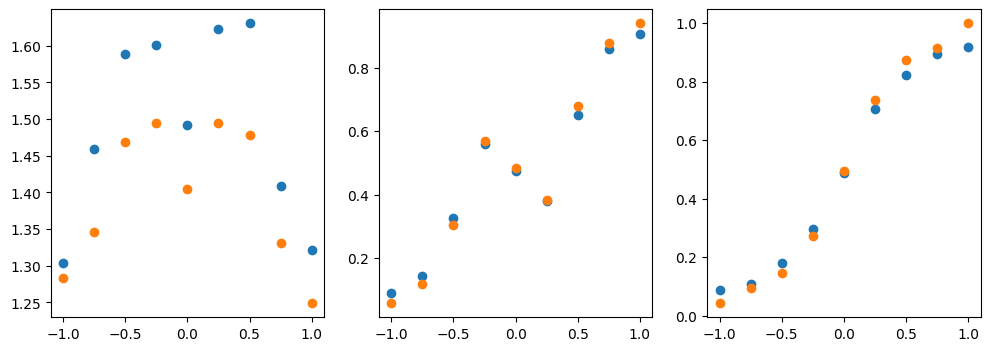

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

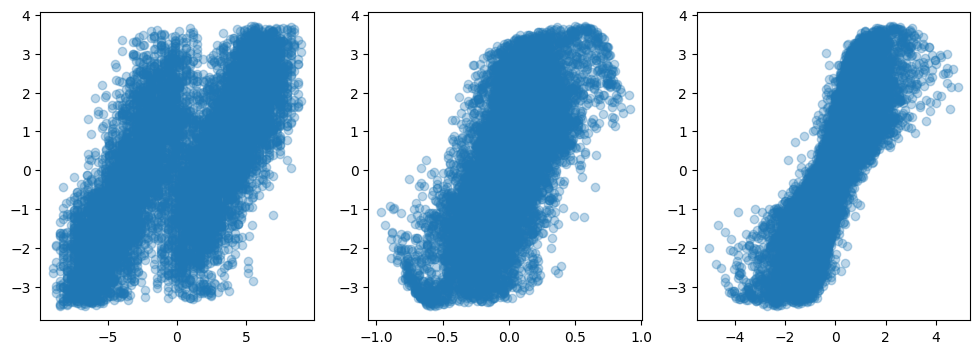

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] + X_test[:, 1] - X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 4] + X_test[:, 5] - X_test[:, 6] - X_test[:, 7], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
a1 = X_test[:, 0]*X_test[:, 4] +X_test[:, 1]*X_test[:, 5]
a2 = X_test[:, 2]*X_test[:, 6] +X_test[:, 3]*X_test[:, 7]
plt.scatter(a1 - a2, pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

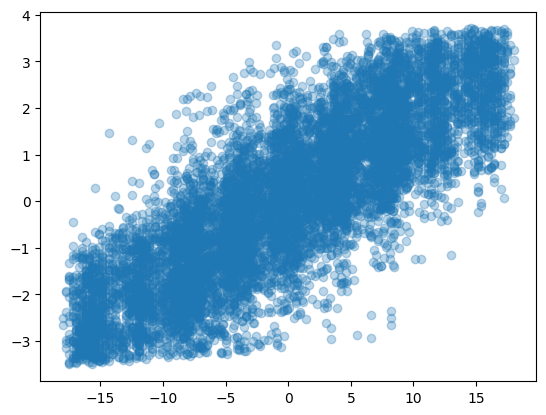

In [21]:
plt.scatter(4*X_test[:, 0] + X_test[:, 1] - 4*X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);